In [1]:
import numpy as np
import pandas as pd
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path, calculate_rmse, plot_rmse_per_epoch, generate_data, compare_tickers_scatter
from qiskit.providers.fake_provider import GenericBackendV2
from sklearn.metrics import mean_squared_error

## Load the model

In [2]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
print(latest_model_path)

models/models_0110.2322


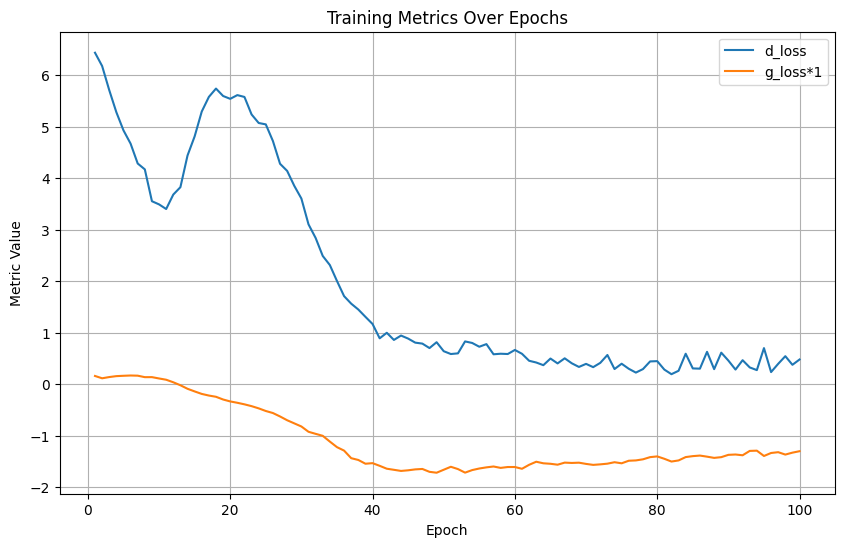

In [3]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1)

In [4]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

## Load data

In [5]:
# Load data
feature_data, target_data = process_model_data(targets, features, tickers)

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d

(1003, 32) (1003, 8)


2025-10-02 05:43:41.229237: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-02 05:43:41.229268: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-02 05:43:41.229274: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-02 05:43:41.229290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-02 05:43:41.229299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load the Qiskit circuit

[Parameter(AAAA), Parameter(AAAB), Parameter(AAAC), Parameter(AAAD), Parameter(AAAE), Parameter(AAAF), Parameter(AAAG), Parameter(AAAH), Parameter(AAAI), Parameter(AAAJ), Parameter(AAAK), Parameter(AAAL), Parameter(AAAM), Parameter(AAAN), Parameter(AAAO), Parameter(AAAP), Parameter(AAAQ), Parameter(AAAR), Parameter(AAAS), Parameter(AAAT), Parameter(AAAU), Parameter(AAAV), Parameter(AAAW), Parameter(AAAX), Parameter(AAAY), Parameter(AAAZ), Parameter(AABA), Parameter(AABB), Parameter(AABC), Parameter(AABD), Parameter(AABE), Parameter(AABF), Parameter(WAAA), Parameter(WAAB), Parameter(WAAC), Parameter(WAAD), Parameter(WAAE), Parameter(WAAF), Parameter(WAAG), Parameter(WAAH), Parameter(WAAI), Parameter(WAAJ), Parameter(WAAK), Parameter(WAAL), Parameter(WAAM), Parameter(WAAN), Parameter(WAAO), Parameter(WAAP), Parameter(WAAQ), Parameter(WAAR), Parameter(WAAS), Parameter(WAAT), Parameter(WAAU), Parameter(WAAV), Parameter(WAAW), Parameter(WAAX), Parameter(WAAY), Parameter(WAAZ), Parameter(WAB

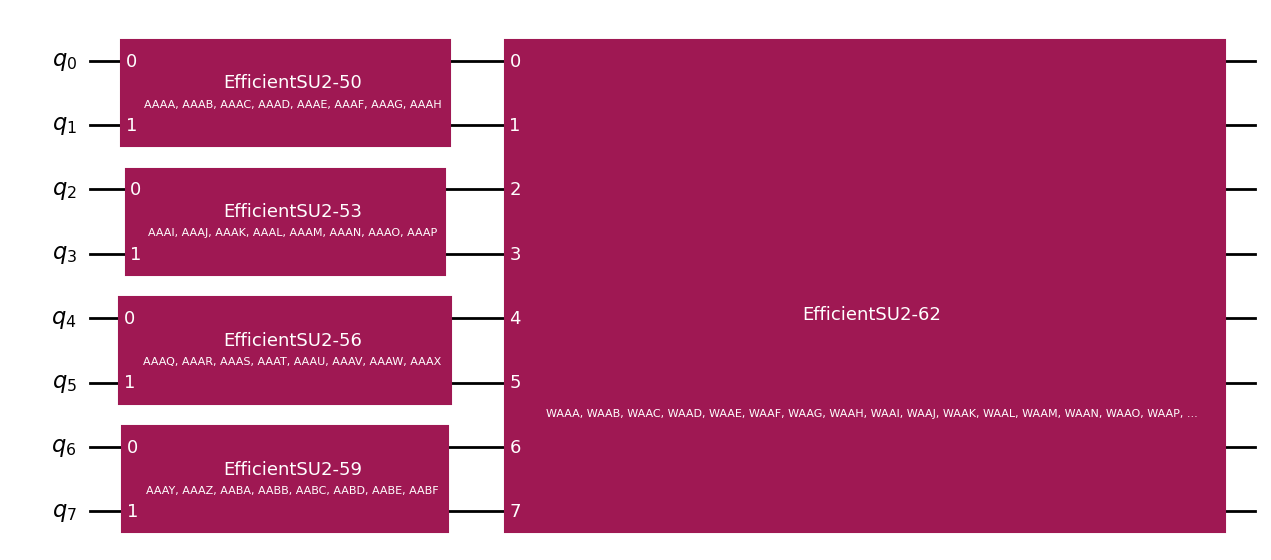

In [6]:
# Load circuit
qc= two_qubit_circuit_tickers(tickers)
print(list(qc.parameters))
qc.draw('mpl')

In [7]:
# Load weights
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [8]:
# Generate Data
# data is randomly sampled so returns the generated data along with the associated real data (if samplig=True)

backend = GenericBackendV2(num_qubits=qc.num_qubits)

outputs, target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 100,
)

## Finding the Root Mean Squared Errors
This is a better accuracy metric for us as the generator/discriminator loss doesn't tell us much

An RMSE of 0.10 means we are off by 10%

In [9]:
# Calculate RMSE for each ticker and output feature
rmse_dict = calculate_rmse(
    generated_data= outputs,
    target_data= target_outputs, 
    ticker_labels= tickers,
    target_labels = targets
)

for k, v in rmse_dict.items():
        print(f"{k}: {v:.4f}")

avg_rmse = mean_squared_error(target_outputs, outputs)
print(f"Average RMSE: {avg_rmse}")

GOOG_OC_next: 0.8392
GOOG_CO_next: 0.9040
AAPL_OC_next: 1.0052
AAPL_CO_next: 0.9722
MSFT_OC_next: 1.1671
MSFT_CO_next: 1.0550
AMZN_OC_next: 0.8110
AMZN_CO_next: 1.4294
Average RMSE: 1.0816930532455444


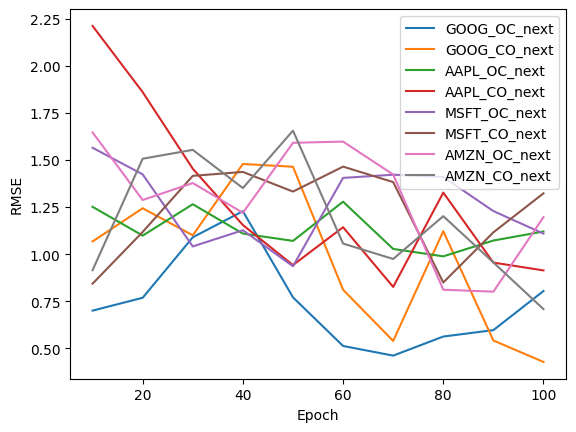

In [10]:
# Plot the RMSE per epoch
rmse_per_epoch=plot_rmse_per_epoch(model_path=latest_model_path,
                    qc=qc, 
                    feature_data=feature_data, 
                    target_data=target_data, 
                    target_labels=targets, 
                    ticker_labels=tickers, 
                    sample_size = 100,
                    every_n_epochs=10,
)

## Comparing to random weights

In [11]:
random_weights = np.random.randn(len(loaded_weights))

random_outputs, random_target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 500,
)
random_rmse = mean_squared_error(random_target_outputs, random_outputs)
print(f"Average RMSE for random weights: {random_rmse}")
print(f"Average RMSE for trained weights: {avg_rmse}")

Average RMSE for random weights: 1.0753190517425537
Average RMSE for trained weights: 1.0816930532455444


## Plotting the ticker comparison distributions

In [12]:
# Turning the results into a df
columns = [f"{ticker}_{target}" for ticker in tickers for target in targets]

df_gen = pd.DataFrame(outputs, columns=columns)
df_real = pd.DataFrame(target_outputs, columns=columns)


In [13]:
df_gen.head()

,GOOG_OC_next,GOOG_CO_next,AAPL_OC_next,AAPL_CO_next,MSFT_OC_next,MSFT_CO_next,AMZN_OC_next,AMZN_CO_next
0,-1.454362,-0.612587,0.187915,1.751256,-2.765200,-1.577436,-0.524067,-1.480624
1,-0.588453,-0.837532,-0.210781,1.371846,-1.515284,-1.028069,-0.865334,-0.791867
2,0.104250,0.568959,-0.214584,0.202131,-2.190327,-1.388067,-0.074296,-1.698302
3,-1.025214,0.931061,-0.039259,0.447905,-0.482653,-2.127787,-0.579851,-2.042684
4,-0.236410,-1.240317,-0.101972,2.000146,0.407956,-0.201656,-0.248245,-1.173857


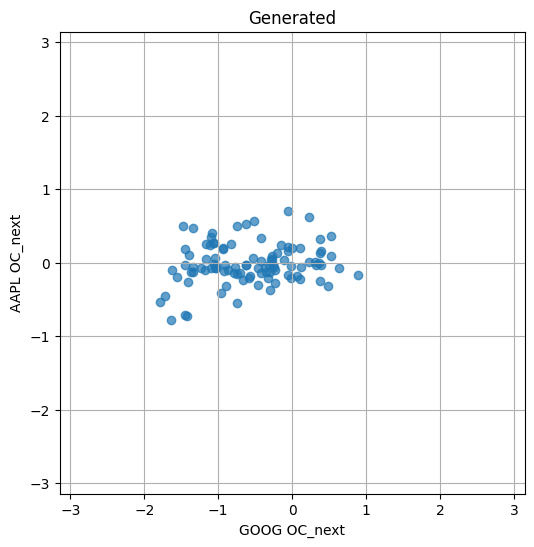

In [18]:
compare_tickers_scatter(df_gen, "GOOG", "AAPL", title= "Generated", feature="OC_next")

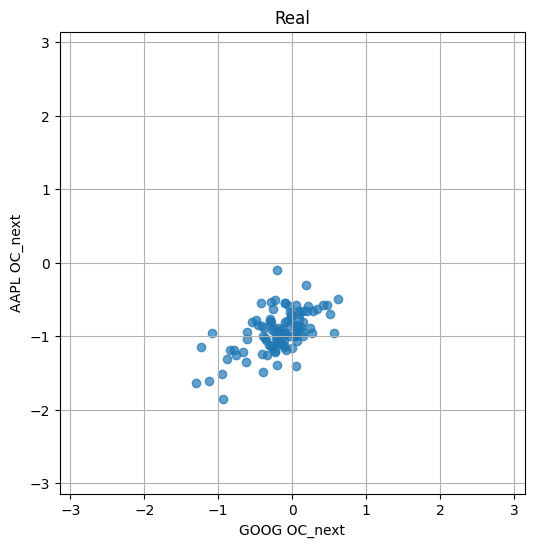

In [19]:
compare_tickers_scatter(df_real, "GOOG", "AAPL",title= "Real", feature="OC_next")